# Walktimes to  TTC Stop #
## Introduction ##

In this tutorial we will analyse walk times from address points within the City of Toronto to the Toronto Transit Commission (TTC) Stops. TTC stops can include subway, LRT, street car and bus. The analysis will use Panada to perform the network calculation. The results will be displayed City wide and at the level of an individual City of Toronto Neighbourhood Improvement Area. Neighbourhood Improvement Areas have been chosen as one of the domains used to determine them is the physical surroundings including access to transportation.

The analysis will use data from the City of Toronto's Open Data site including TTC Stop (https://open.toronto.ca/dataset/ttc-routes-and-schedules/),  the City of Toronto's pedestrian network (https://open.toronto.ca/dataset/pedestrian-network/), Toronto One Address Repository address point data (https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/) and Neighbourhood Improvement Areas (https://open.toronto.ca/dataset/neighbourhood-improvement-areas/). 

The TTC Routes and Schedules zip file contains route definitions, stop patterns, stop locations, and schedules. For this tutorial we will be using the stops.txt file.

The City of Toronto pedestrian network was a collective effort by the City of Toronto's Information and Technology Division's Data Analytics and Visualization team (DAV) and the City of Toronto's Transportation Services Division. A pedestrian network based on sidewalk centerlines and pedestrian-assets (e.g., sidewalks, crosswalks, pedestrian controlled crossings) was created with the focus being placed on the topological consistency over spatial accuracy. Meaning that the sidewalk centerlines are not necessarily spatially located along with the actual locations of the sidewalk geographically, but the connections between different sidewalk segments were maintained as being a higher priority.

The City of Toronto address point data contains over 500,000 address points within the city. A readme file is also included which explains the each of the attributes. 

Neighbourhood Improvement Areas are specially-selected and designated neighbourhoods in the City of Toronto found to have inequities on several indicators of well-being. Currently 31 out of 140 neighbourhoods are designated as NIAs as part of the Toronto Strong Neighbourhoods 2020 (TSNS2020) project. Please see the link for further information (https://www.toronto.ca/city-government/data-research-maps/research-reports/social-reports/toronto-strong-neighbourhoods-strategy-2020/).


In [1]:
#Import libraries
import pandas as pd
import geopandas as gpd 
import pandas as pd
import os
import shapely
import numpy as np
import psycopg2
import networkx as nx
import multiprocessing as mp
import pandana as pdna
import h5py
import shapefile
import pyproj
import matplotlib.pyplot as plt
from pandana import Network
from mpl_toolkits.basemap import Basemap
from shapely import ops
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point, box
from pandana import Network
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from shapely.geometry import *
from fiona.crs import from_epsg
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

pd.options.display.max_rows = 120

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


## Step 1: Importing and Cleaning Data ##
#### Importing Data ####

We can read the ttc stop text file and create geometry using the latitude longitude columns supplied in the data. We can use the geopandas.read_file function to read the pednet, address and Neighbourhood Improvement Areas ESRI shape files and reproject them to EPSG 2019. Please see the link for the description of EPSG 2019 (https://epsg.io/2019).

#### Read TTC Stop Data ####

Read the TTC Stop data text file and create the spatial layer using the latitude and longitude provided in the file. The layer will be reprojected to EPSG 2019.

In [2]:
# reading ttc stop csv file
# https://open.toronto.ca/dataset/ttc-routes-and-schedules/
# Go to Download Data
ttc_stop = pd.read_csv('./stops.txt', delimiter= ',')
ttc_stop.head(5)

stop_id stop_code                       stop_name  stop_desc   stop_lat   stop_lon  zone_id  stop_url  location_type  parent_station  wheelchair_boarding
0      262       662       DANFORTH RD AT KENNEDY RD        NaN  43.714379 -79.260939      NaN       NaN            NaN             NaN                    2
1      263       929      DAVENPORT RD AT BEDFORD RD        NaN  43.674448 -79.399659      NaN       NaN            NaN             NaN                    1
2      264       940       DAVENPORT RD AT DUPONT ST        NaN  43.675511 -79.401938      NaN       NaN            NaN             NaN                    2
3      265      1871  DAVISVILLE AVE AT CLEVELAND ST        NaN  43.702088 -79.378112      NaN       NaN            NaN             NaN                    1
4      266     11700          DISCO RD AT ATTWELL DR        NaN  43.701362 -79.594843      NaN       NaN            NaN             NaN                    1

In [3]:
#include columns needed for the project and renaming stop_lat and stop_lon columns
ttc_stop = ttc_stop[['stop_id', 'stop_code','stop_name','stop_lat', 'stop_lon']]
ttc_stop = ttc_stop.rename(columns={'stop_lat': 'latitude','stop_lon':'longitude' })
ttc_stop.head(5)

stop_id stop_code                       stop_name   latitude  longitude
0      262       662       DANFORTH RD AT KENNEDY RD  43.714379 -79.260939
1      263       929      DAVENPORT RD AT BEDFORD RD  43.674448 -79.399659
2      264       940       DAVENPORT RD AT DUPONT ST  43.675511 -79.401938
3      265      1871  DAVISVILLE AVE AT CLEVELAND ST  43.702088 -79.378112
4      266     11700          DISCO RD AT ATTWELL DR  43.701362 -79.594843

In [4]:
# create geopanda dataframe add crs lat long
ttc_stop['geometry'] = list(zip(ttc_stop.longitude, ttc_stop.latitude))
ttc_stop['geometry'] = ttc_stop['geometry'].apply(Point)

# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
ttc_stop = gpd.GeoDataFrame(ttc_stop, crs=crs, geometry='geometry')
ttc_stop = ttc_stop.to_crs({'init': 'epsg:2019'})

# calculating x and y which will be used later to find nearest ttc stop to address 
ttc_stop['x'] = ttc_stop.geometry.x
ttc_stop['y'] = ttc_stop.geometry.y


In [5]:
ttc_stop.crs

{'init': 'epsg:2019'}

In [6]:
ttc_stop.head(2)

stop_id stop_code                   stop_name   latitude  longitude                                     geometry              x             y
0      262       662   DANFORTH RD AT KENNEDY RD  43.714379 -79.260939   POINT (324064.5444378475 4841414.80814087)  324064.544438  4.841415e+06
1      263       929  DAVENPORT RD AT BEDFORD RD  43.674448 -79.399659  POINT (312891.2672263168 4836955.832799464)  312891.267226  4.836956e+06

#### Explore TTC Stop ####

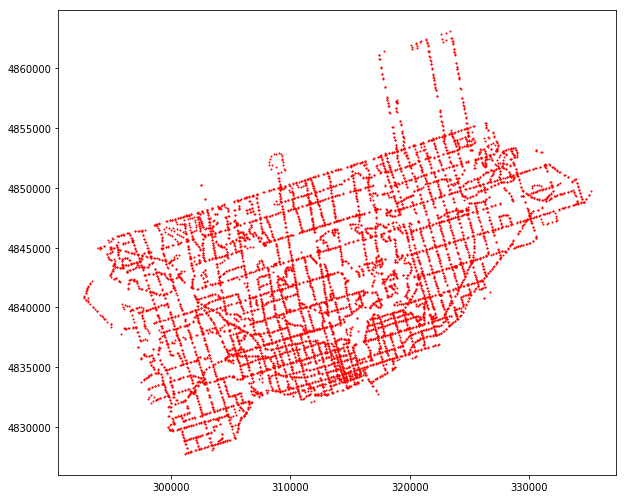

In [7]:
#plotting
ax = ttc_stop.plot(figsize=(10, 10),color='red', markersize =1)


#### Read Pedestrian Network Data ####

Read the Pedestrian Network line shape file and reproject to EPSG 2019

In [8]:
# reading pednet file
pednet = gpd.read_file("zip://./pednet.zip")

pednet.head(2)

OBJECTID  road_type  sdwlk_code              sdwlk_desc  crosswalk cwalk_type    px px_type     length                                           geometry
0         1      Local         7.0  Sidewalk on both sides          0       None  None    None  93.867680  LINESTRING (-79.56395458514206 43.737814184044...
1         2  Collector         7.0  Sidewalk on both sides          0       None  None    None  32.546284  LINESTRING (-79.567911749069 43.63617196303007...

In [9]:
pednet.crs

{'init': 'epsg:4326'}

In [10]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
pednet = gpd.GeoDataFrame(pednet, crs=crs, geometry='geometry')
pednet = pednet.to_crs({'init': 'epsg:2019'})

In [11]:
# remove length column to avoid confusion
pednet = pednet[['OBJECTID', 'road_type', 'sdwlk_code', 'sdwlk_desc', 'crosswalk', 'cwalk_type', 'px', 'px_type','geometry']]
pednet.head(2)

OBJECTID  road_type  sdwlk_code              sdwlk_desc  crosswalk cwalk_type    px px_type                                           geometry
0         1      Local         7.0  Sidewalk on both sides          0       None  None    None  LINESTRING (299648.2789610377 4843992.54504967...
1         2  Collector         7.0  Sidewalk on both sides          0       None  None    None  LINESTRING (299320.2737241704 4832700.97291398...

#### Explore the Pedestrian Network Data ####
Create bar plot and plots of pednet

#### Create a bar plot showing the distribution of road types

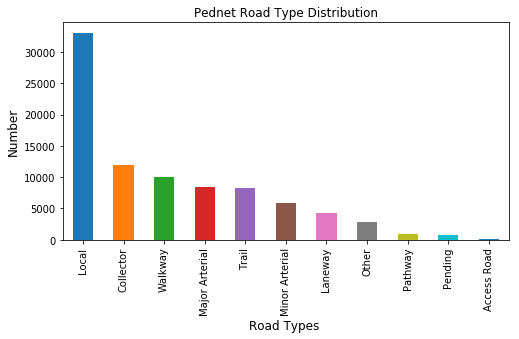

In [12]:
# distribution of road types in pednet

#plot
plt.figure(figsize=(8,4))
#ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Pednet Road Type Distribution")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Road Types ', fontsize=12)

pednet.road_type.value_counts().plot.bar()


#### Create a plot of the city wide Pedestrian Network

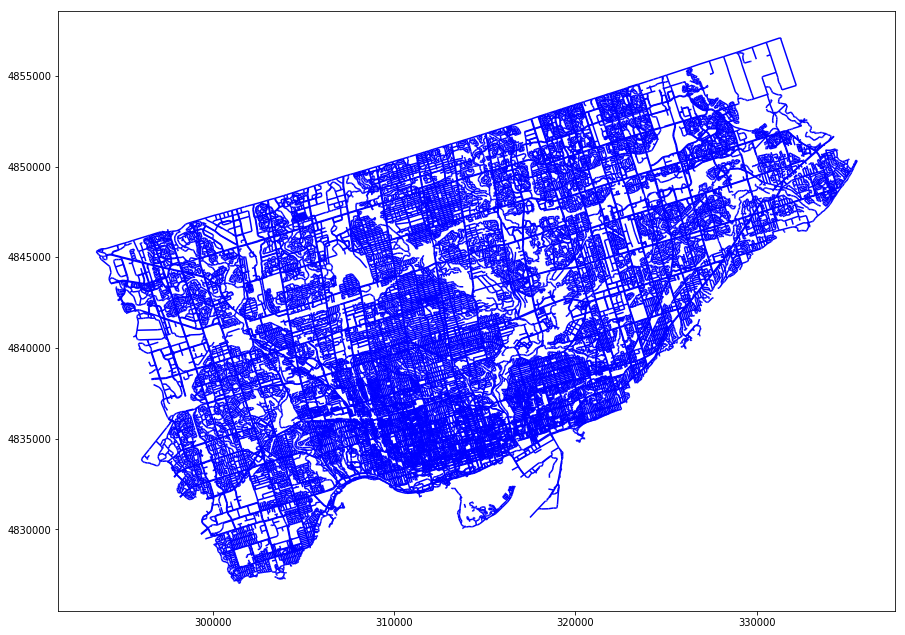

In [13]:
# plotting pednet layer
ax = pednet.plot(figsize=(15, 15),color='blue', markersize =1)


#### Create a plot showing the Pedestrian Network at the city block level

In the plot below we see the cases where sidewalks are on both sides of the streets. Single lines represent several different features including local roads, walkways, laneways or private roads.   

[(4834000, 4835000), (311000, 312000)]

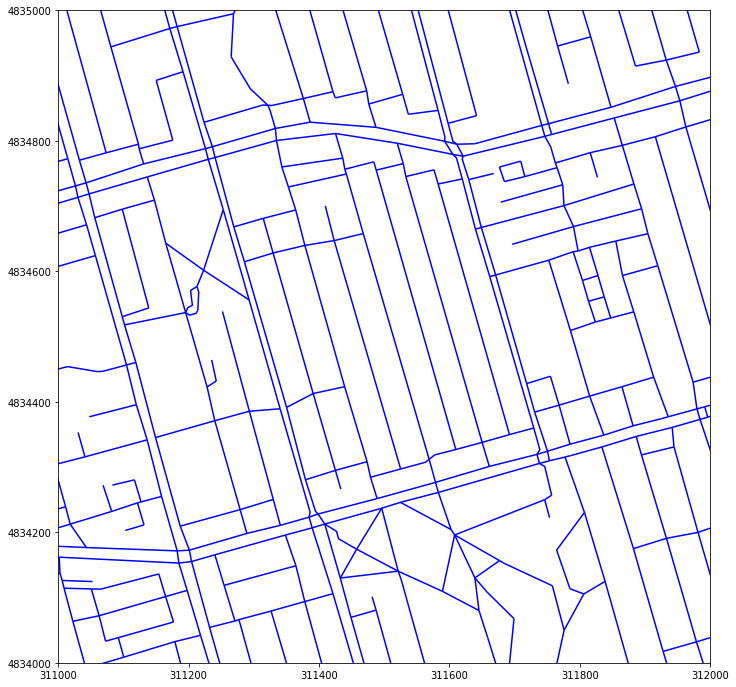

In [14]:
# plotting pednet layer with limits set
ax = pednet.plot(figsize=(12, 12),color='blue', markersize =1)
ax.set(xlim=(311000, 312000), ylim=(4834000, 4835000))

#### Load Address Data ####

Read the Address point shape file and reproject to EPSG 2019

In [15]:
# reading municipal address point shape file
# https://open.toronto.ca/dataset/address-points-municipal-toronto-one-address-repository/
# Go to Download Data
address = gpd.read_file("zip://./municipal-address-points-wgs84-latitude-longitude.zip")
address.head(2)

GEO_ID    LINK MAINT_STAG ADDRESS            LFNAME  LONUM LONUMSUF  HINUM HINUMSUF ARC_SIDE  DISTANCE   FCODE                FCODE_DES CLASS  NAME           X            Y  LONGITUDE   LATITUDE   OBJECTID   MUN_NAME            WARD_NAME                            geometry
0  1015200  914764    REGULAR      22  Lloyd George Ave     22     None      0     None        L     78.08  100001  Low Density Residential  Land  None  301211.152  4827985.051 -79.544251  43.593789  4104309.0  Etobicoke  Etobicoke-Lakeshore  POINT (-79.544251409 43.593788977)
1  1015189  914764    REGULAR       3  Lloyd George Ave      3     None      0     None        R     22.96  100001  Low Density Residential  Land  None  301272.174  4827946.759 -79.543495  43.593445  4104306.0  Etobicoke  Etobicoke-Lakeshore   POINT (-79.543495353 43.59344452)

In [16]:
# change column names from upper to lower case
address.columns = map(str.lower, address.columns)

#include columns needed for the project
address = address[['geo_id', 'maint_stag','address','lfname','x','y','longitude','latitude','objectid','mun_name','ward_name','geometry']]
address.head(2)

geo_id maint_stag address            lfname           x            y  longitude   latitude   objectid   mun_name            ward_name                            geometry
0  1015200    REGULAR      22  Lloyd George Ave  301211.152  4827985.051 -79.544251  43.593789  4104309.0  Etobicoke  Etobicoke-Lakeshore  POINT (-79.544251409 43.593788977)
1  1015189    REGULAR       3  Lloyd George Ave  301272.174  4827946.759 -79.543495  43.593445  4104306.0  Etobicoke  Etobicoke-Lakeshore   POINT (-79.543495353 43.59344452)

In [17]:
address.crs

{'init': 'epsg:4326'}

In [18]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
address = gpd.GeoDataFrame(address, crs=crs, geometry='geometry')
address = address.to_crs({'init': 'epsg:2019'})

#### Explore address point data

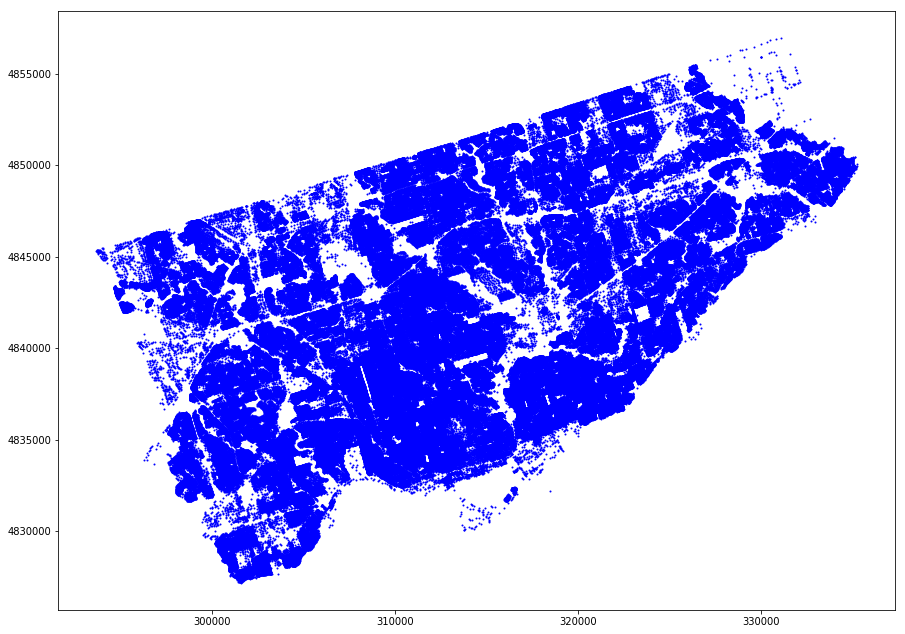

In [19]:
ax = address.plot(figsize=(15, 15),color='blue', markersize =1)

#### Create a plot showing the address point data at the city block level

[(4834200, 4834800), (311200, 311800)]

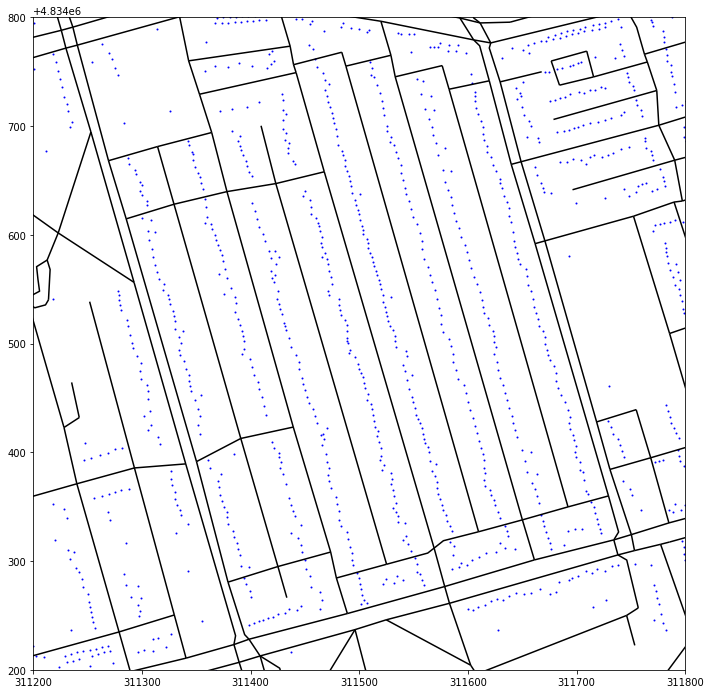

In [20]:
# plotting address layer with limits set
ax = address.plot(figsize=(12, 12),color='blue', markersize =1)
pednet.plot(ax=ax,color='black', markersize =2)
ax.set(xlim=(311200, 311800), ylim=(4834200, 4834800))

#### Neighbourhood Improvement Areas ####

Read the Neighbourhood Improvement Areas polygon shape file and reproject to EPSG 2019

In [21]:
# reading Neighbourhood Improvement Areas polygon shape file
# https://open.toronto.ca/dataset/neighbourhood-improvement-areas/
# Go to Download Data
nia = gpd.read_file("zip://./neighbourhood-improvement-areas-wgs84.zip")
nia.head(3)

AREA_ID    DATE_EFF    DATE_EXP  AREA_AT_ID  AREA_TP_ID  PARNT_AREA AREA_TYPE  AREA_CL_ID AREA_CL AREA_S_CD AREA_L_CD                         AREA_NAME                          AREA_DSC  FEAT_CD FEAT_C_DSC  TR_ID_CRT  TR_ID_EXP           X            Y  LONGITUDE   LATITUDE    OBJECTID                                           geometry
0  25886593  2014-05-12  3000-01-01    25926665         602       49885      CNBH           0    None       027       027      York University Heights (27)      York University Heights (27)        0       None     105211         -1  305679.417  4847086.588 -79.488883  43.765736  16491553.0  POLYGON ((-79.505287916 43.759873494, -79.5048...
1  25886723  2014-05-12  3000-01-01    25926718         602       49885      CNBH           0    None       003       003  Thistletown-Beaumond Heights (3)  Thistletown-Beaumond Heights (3)        0       None     105211         -1  299670.030  4844005.846 -79.563491  43.737988  16492401.0  POLYGON ((-79.577514796 43.733835422, -79.5780...
2  25886334  2014-05-12  3000-01-01    25926719         602       49885      CNBH           0    None       055       055             Thorncliffe Park (55)             Thorncliffe Park (55)        0       None     105211         -1  316874.178  4840655.317 -79.349984  43.707749  16492417.0  POLYGON ((-79.335417828 43.70319967, -79.33573...

In [22]:
# change column names from upper to lower case
nia.columns = map(str.lower, nia.columns)

#include columns needed for the project
nia = nia[['area_id','area_s_cd','area_name','geometry']]
nia.head(2)

area_id area_s_cd                         area_name                                           geometry
0  25886593       027      York University Heights (27)  POLYGON ((-79.505287916 43.759873494, -79.5048...
1  25886723       003  Thistletown-Beaumond Heights (3)  POLYGON ((-79.577514796 43.733835422, -79.5780...

In [23]:
nia.crs

{'init': 'epsg:4326'}

In [24]:
# reprojecting epsg 4386 (wgs84) to epsg 2019 (mtm nad 27)
crs = {'init': 'epsg:4326'}
nia = gpd.GeoDataFrame(nia, crs=crs, geometry='geometry')
nia = nia.to_crs({'init': 'epsg:2019'})

#### Explore Neighbourhood Improvement Areas

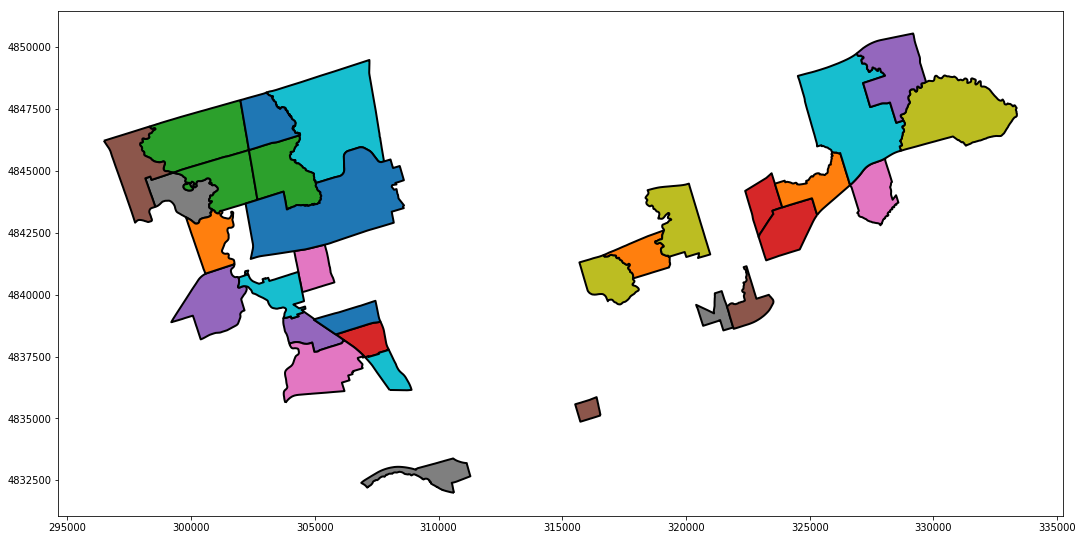

In [25]:
# plot Neighbourhood Improvement Areas
ax = nia.plot(figsize=(18, 13), column='area_name',edgecolor='black', linewidth=2)


## Step 2: Build Pandana Network ##

Pandana is a Python package that uses contraction hierarchies to perform rapid network calculations including shortest paths and accessibility buffers. 

The link provides an introduction to the Pandana Network (https://udst.github.io/pandana/introduction.html).

#### Create Network Graph Code Function

In [26]:
# creating network graph code
def create_graph(gdf, precision=3):
    '''Create a networkx given a GeoDataFrame of lines. Every line will
    correspond to two directional graph edges, one forward, one reverse. The
    original line row and direction will be stored in each edge. Every node
    will be where endpoints meet (determined by being very close together) and
    will store a clockwise ordering of incoming edges.
    '''
      
    G = nx.Graph()

    def make_node(coord, precision):
        return tuple(np.round(coord, precision))

    # Edges are stored as (from, to, data), where from and to are nodes.
    def add_edges(row, G):
        geometry = row.geometry
        coords = list(geometry.coords)
        geom_r = LineString(coords[::-1])
        coords_r = geom_r.coords
        start = make_node(coords[0], precision)
        end = make_node(coords[-1], precision)
        # Add forward edge
        fwd_attr ={}
        for k,v in row.items():
            fwd_attr[k]=v
        fwd_attr['forward']= 1
       #fwd_attr['geometry']=  geometry
        fwd_attr['length']=  geometry.length

        fwd_attr['visited']= 0

        G.add_edge(start, end, **fwd_attr)

    gdf.apply(add_edges, axis=1, args=[G])

    return G

##### Create a network graph from the function above ####

In [27]:
# creating network graph
G = create_graph(pednet)
#from G to urbanaccess network model - one node idx,x,y one edge from to weight
#G.edges(data=True)

In [28]:
# get network "from" and "to" from nodes
edges = nx.to_pandas_edgelist(G,'from','to')
to = edges['to'].tolist()
fr = edges['from'].tolist()
fr = list(set(fr))
to = list(set(to))
to.extend(fr)
nodes = list(set(to))
nodes = pd.DataFrame(nodes)
nodes.columns=['x', 'y']
nodes['xy'] = nodes.apply(lambda z: (z.x,z.y),axis=1)


In [29]:
# Assigning node ids to to_node and from_node

nodes['id'] = nodes.index
edges['to_node']=edges['to'].map(nodes.set_index('xy').id)
edges['from_node']=edges['from'].map(nodes.set_index('xy').id)
edges.head(3)


from                         to cwalk_type  forward road_type                  sdwlk_desc  visited     length px_type    px  crosswalk                                           geometry  sdwlk_code  OBJECTID  to_node  from_node
0  (299648.279, 4843992.545)  (299731.442, 4843949.007)       None        1     Local      Sidewalk on both sides        0  93.870579    None  None          0  LINESTRING (299648.2789610377 4843992.54504967...         7.0         1    51829      56074
1  (299648.279, 4843992.545)  (299603.437, 4844062.355)       None        1     Local      Sidewalk on both sides        0  82.971308    None  None          0  LINESTRING (299603.437224735 4844062.355196978...         7.0     84099    48292      56074
2  (299731.442, 4843949.007)  (299812.731, 4843907.011)       None        1     Local  No sidewalk on either side        0  91.495742    None  None          0  LINESTRING (299731.4420138962 4843949.00664981...         3.0     25712    42948      51829

#### Creating and Saving Pandana Network ####

Create the Pandana Network and save the file in case you lose the network in memory

In [30]:
# creating pandana network

transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_node"],
                               edges["to_node"],
                               pd.DataFrame([edges['length']]).T,
                               twoway=True)

# saving walkability file is optional. It can be used in the next steps if you don't have transit_ped_net in memory
transit_ped_net.save_hdf5('./walkability.hd5')


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


#### Reading Pandana Network file ####
This step is only required if you do not already have transit_ped_net in memory

In [45]:
transit_ped_net = pdna.Network.from_hdf5('walkability.hd5')


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:81: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:84: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:90: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


#### Precompute a Horizon Distance
It’s probably a good idea to precompute a given horizon distance so
that aggregations don’t perform the network queries unnecessarily.
This is done by calling the following code, where 1000 meters is used as the horizon distance:

In [31]:
#precompute a given horizon distance of 1000 meters
transit_ped_net.precompute(1000)
transit_ped_net.edges_df.head(2)

from     to     length
0  56074  51829  93.870579
1  56074  48292  82.971308

#### Get the nearest pednet intersection node ids for each point from the address and ttc stop layers

In [32]:
#get node_ids for points for each layer
x, y = ttc_stop.x, ttc_stop.y 
ttc_stop["node_ids"] = transit_ped_net.get_node_ids(x, y)
transit_ped_net.set(ttc_stop["node_ids"], name="ttc_stop")

# using x and y coordinates from address that are utm nad27 
x, y = address.x, address.y
address["node_ids"] = transit_ped_net.get_node_ids(x, y)


/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())
/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


#### Get 10 nearest ttc stop points

The 10 nearest TTC stops will be determined.

In [33]:
#get nearest points with id
n=10
maxdistance = 5000

transit_ped_net.set_pois("ttc_stop", maxdistance , n, ttc_stop.x, ttc_stop.y)
ttc_stop_walk_distances = transit_ped_net.nearest_pois(maxdistance , "ttc_stop", num_pois=n, include_poi_ids=False)

ttc_stop_walk_distances.head(3)

/opt/anaconda3/lib/python3.6/site-packages/pandana/network.py:370: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


1           2           3           4           5           6           7           8           9           10
0   83.728996   83.728996  187.341003  205.121994  407.338013  408.652008  422.954987  426.464996  507.778015  511.807007
1   75.160004  236.988998  268.595001  268.595001  268.595001  268.595001  282.303009  316.358002  368.242004  550.038025
2  476.973999  482.144012  617.570984  617.570984  719.544006  759.166016  779.781982  796.690002  802.825989  822.979004

#### Renaming columns

In [34]:
# Rename columns 1 to 10 to d_ttcstop_0 to d_ttcstop_9.

n=10

columns =  ['d_ttcstop_'+str(i) for i in range(0,n,1)]

ttc_stop_walk_distances.columns = columns
ttc_stop_walk_distances.head(2)

d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9
0    83.728996    83.728996   187.341003   205.121994   407.338013   408.652008   422.954987   426.464996   507.778015   511.807007
1    75.160004   236.988998   268.595001   268.595001   268.595001   268.595001   282.303009   316.358002   368.242004   550.038025

#### Calculating walk distance from address points to ttc_stops and get each point id from ttc stop.  


In [35]:
for i in range(10):
    address['d_ttcstop_{}'.format(i)]=address['node_ids'].map(ttc_stop_walk_distances['d_ttcstop_{}'.format(i)])
address.head(3)

geo_id maint_stag address            lfname           x            y  longitude   latitude   objectid   mun_name            ward_name                                     geometry  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9
0   1015200    REGULAR      22  Lloyd George Ave  301211.152  4827985.051 -79.544251  43.593789  4104309.0  Etobicoke  Etobicoke-Lakeshore  POINT (301226.8927674703 4827991.254561239)      1913   349.734009   587.861023   666.593994   699.388977   764.556030   834.200989   850.239990   944.494995   968.588989   972.382996
1   1015189    REGULAR       3  Lloyd George Ave  301272.174  4827946.759 -79.543495  43.593445  4104306.0  Etobicoke  Etobicoke-Lakeshore   POINT (301287.9209440018 4827952.95590811)     14935   449.546997   685.513977   766.406982   799.202026   862.208984   931.854004   947.893005  1044.307983  1068.401978  1072.196045
2  20140046    REGULAR      7A  Lloyd George Ave  301265.553  4827966.490 -79.543577  43.593622  4104315.0  Etobicoke  Etobicoke-Lakeshore  POINT (301281.2996148061 4827972.687101001)     14935   449.546997   685.513977   766.406982   799.202026   862.208984   931.854004   947.893005  1044.307983  1068.401978  1072.196045

#### Calculate minutes fields based on distances

We are applying an average pedestrian walking speed of 1.2 m/s which is used by the City of Toronto Transportation Services uses.The link below is to the TRANSPORTATION SERVICES STANDARD OPERATING PRACTICE - TRAFFIC SYSTEMS OPERATIONS document which discusses the standardized walk speed of 1.2 m/s.

https://www.toronto.ca/wp-content/uploads/2019/01/96a8-TS_Traffic-Management_Pedestrian-Timing-Guidelines.pdf

In [36]:
# Calculate minutes fields based on distances. This cell takes 1.5 minutes to run.

address['m_ttcstop_0'] = address.apply(lambda row: row.d_ttcstop_0/(1.2*60), axis=1)
address['m_ttcstop_1'] = address.apply(lambda row: row.d_ttcstop_1/(1.2*60), axis=1)
address['m_ttcstop_2'] = address.apply(lambda row: row.d_ttcstop_2/(1.2*60), axis=1)
address['m_ttcstop_3'] = address.apply(lambda row: row.d_ttcstop_3/(1.2*60), axis=1)
address['m_ttcstop_4'] = address.apply(lambda row: row.d_ttcstop_4/(1.2*60), axis=1)
address['m_ttcstop_5'] = address.apply(lambda row: row.d_ttcstop_5/(1.2*60), axis=1)
address['m_ttcstop_6'] = address.apply(lambda row: row.d_ttcstop_6/(1.2*60), axis=1)
address['m_ttcstop_7'] = address.apply(lambda row: row.d_ttcstop_7/(1.2*60), axis=1)
address['m_ttcstop_8'] = address.apply(lambda row: row.d_ttcstop_8/(1.2*60), axis=1)
address['m_ttcstop_9'] = address.apply(lambda row: row.d_ttcstop_9/(1.2*60), axis=1)
address.head(3)

geo_id maint_stag address            lfname           x            y  longitude   latitude   objectid   mun_name            ward_name                                     geometry  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9
0   1015200    REGULAR      22  Lloyd George Ave  301211.152  4827985.051 -79.544251  43.593789  4104309.0  Etobicoke  Etobicoke-Lakeshore  POINT (301226.8927674703 4827991.254561239)      1913   349.734009   587.861023   666.593994   699.388977   764.556030   834.200989   850.239990   944.494995   968.588989   972.382996     4.857417     8.164736     9.258250     9.713736    10.618834    11.586125    11.808889    13.117986    13.452625    13.505319
1   1015189    REGULAR       3  Lloyd George Ave  301272.174  4827946.759 -79.543495  43.593445  4104306.0  Etobicoke  Etobicoke-Lakeshore   POINT (301287.9209440018 4827952.95590811)     14935   449.546997   685.513977   766.406982   799.202026   862.208984   931.854004   947.893005  1044.307983  1068.401978  1072.196045     6.243708     9.521027    10.644541    11.100028    11.975125    12.942417    13.165181    14.504278    14.838916    14.891612
2  20140046    REGULAR      7A  Lloyd George Ave  301265.553  4827966.490 -79.543577  43.593622  4104315.0  Etobicoke  Etobicoke-Lakeshore  POINT (301281.2996148061 4827972.687101001)     14935   449.546997   685.513977   766.406982   799.202026   862.208984   931.854004   947.893005  1044.307983  1068.401978  1072.196045     6.243708     9.521027    10.644541    11.100028    11.975125    12.942417    13.165181    14.504278    14.838916    14.891612

## Step 3: Visualize Walking Times ##

In this step we will create a series of visulations illustrating the walking times to the nearest TTC stop across the pedestrian network.

### Walking Times To Closest TTC Stop

In this section we will create a chloropleth map showing the walk times to the closest TTC stop across the City of Toronto. As expected the shortest walk times are along majorial aerterials where TTC stops are located as shown in the second map below where the TTC stops are colour coded red.

/opt/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)
/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Walking Times To Closest TTC Stop')

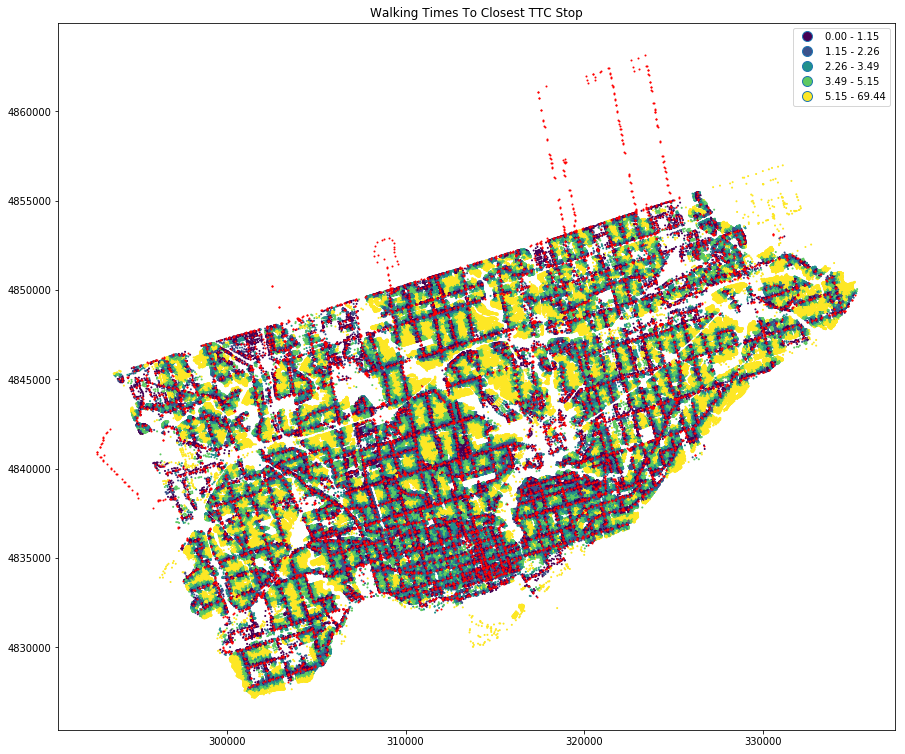

In [37]:
# Walking times To closest TTC Stop with TTC stops added

ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
ttc_stop.plot(ax=ax, color='red', markersize =1)
plt.title('Walking Times To Closest TTC Stop')

### Walking Times To Closest TTC Stop with Neighbourhood Improvement Areas

In this step we will invesitgate the walk times in the Neighbourhood Improvement Areas.

### Get the Neighbourhood Improvement Area centre points
To place a label on each Neighbourhood Improvement Areas in the plot we need to find an identifiable point which exists within each polygon so that we can say where we want the text to be placed.

In [38]:
# Here we find the center points, copy our original df to a new df, and then set 
# the geometry column to the newly created center points column 
# (because a GeoPandas df can only have one geometry column)
nia["center"] = nia["geometry"].centroid
nia_points = nia.copy()
nia_points.set_geometry("center", inplace = True)

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas')

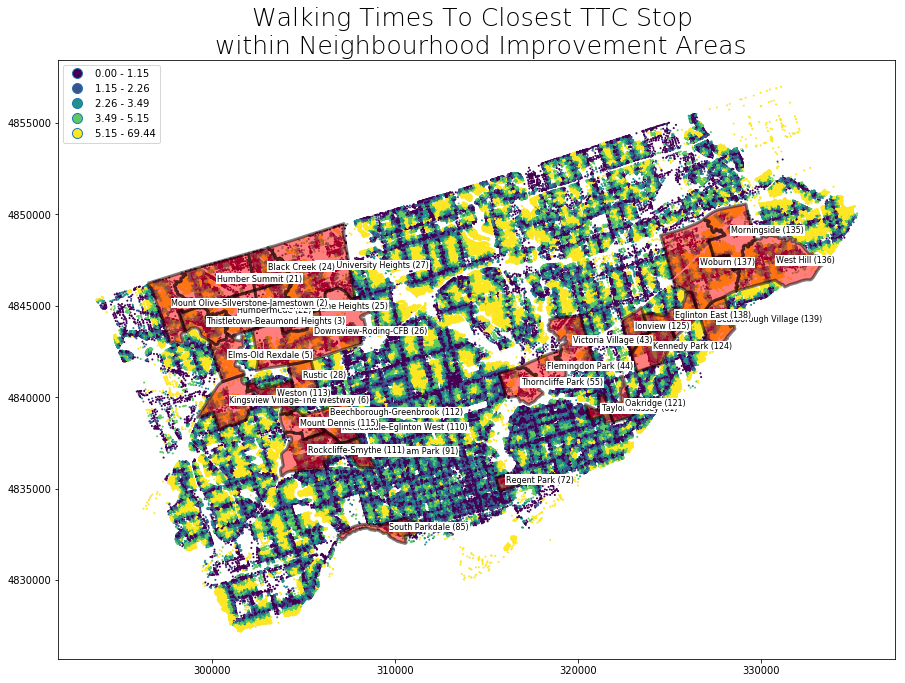

In [39]:
# ploting and adding labels for Neighbourhood Improvement Areas
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
nia.plot(ax=ax, edgecolor='black', facecolor='red', linewidth=3, alpha=.5 )
texts = []

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 8, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))

ax.set_title('Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

#plt.savefig("./walkability_nia.png", dpi=300)

### Addresses within Neighbourhood Improvement Areas
We will now perform a spatial join between Neighbourhood Improvement Area layer and address layer in order to allocate addresses to Neighbourhood Improvement Areas.

In [40]:
# Spatial Join where Neighbourhood Improvement Area polygons are intersected with address points
nia_address = gpd.sjoin(nia, address, op='intersects', how='left')
nia_address.head(2)

area_id area_s_cd                     area_name                                           geometry                                      center  index_right    geo_id maint_stag address     lfname           x            y  longitude   latitude   objectid    mun_name    ward_name  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9
0  25886593       027  York University Heights (27)  POLYGON ((304374.1999541915 4846441.251353574,...  POINT (305695.094973071 4847092.649532764)       235778   5479008    REGULAR     801  Alness St  306821.747  4848464.039 -79.474690  43.778133  4077110.0  North York  York Centre     46986    17.052999    17.052999    40.183998   310.848999   310.848999   331.356995   331.356995   421.743988   448.212006   545.502014     0.236847     0.236847     0.558111     4.317347     4.317347      4.60218      4.60218     5.857555     6.225167     7.576417
0  25886593       027  York University Heights (27)  POLYGON ((304374.1999541915 4846441.251353574,...  POINT (305695.094973071 4847092.649532764)       235779  30073785    REGULAR     803  Alness St  306827.883  4848466.084 -79.474613  43.778151  4077097.0  North York  York Centre     46986    17.052999    17.052999    40.183998   310.848999   310.848999   331.356995   331.356995   421.743988   448.212006   545.502014     0.236847     0.236847     0.558111     4.317347     4.317347      4.60218      4.60218     5.857555     6.225167     7.576417

### Count of addresses in Neighbourhood Improvement Areas

We will now do a count of addresses within each Neighbourhood Improvement Areas and visualize the results in a bar plot.

In [41]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

Woburn (137)                             8491
Downsview-Roding-CFB (26)                7742
West Hill (136)                          5353
Rockcliffe-Smythe (111)                  5161
Glenfield-Jane Heights (25)              4819
York University Heights (27)             4399
Humber Summit (21)                       3748
Weston-Pellam Park (91)                  3407
Keelesdale-Eglinton West (110)           3143
Kennedy Park (124)                       3046
Weston (113)                             3040
Morningside (135)                        2955
Kingsview Village-The Westway (6)        2804
Mount Olive-Silverstone-Jamestown (2)    2771
Humbermede (22)                          2632
Thistletown-Beaumond Heights (3)         2484
Eglinton East (138)                      2432
Victoria Village (43)                    2267
Oakridge (121)                           2162
Mount Dennis (115)                       1961
Black Creek (24)                         1947
Ionview (125)                     

In [42]:
# count of addresses assigned to each Neighbourhood Improvement Area
value_counts = nia_address.area_name.value_counts()
value_counts

# renaming axixs to area_name and resetting index to nia_address_count
nia_address_counts = value_counts.rename_axis('area_name').reset_index(name='nia_address_count')
nia_address_counts

# merge nia_address_counts with nia_address using the area_name which is shared by both dataframes
nia_address = pd.merge(nia_address, nia_address_counts)

nia_address.head(2)

area_id area_s_cd                     area_name                                           geometry                                      center  index_right    geo_id maint_stag address     lfname           x            y  longitude   latitude   objectid    mun_name    ward_name  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9  nia_address_count
0  25886593       027  York University Heights (27)  POLYGON ((304374.1999541915 4846441.251353574,...  POINT (305695.094973071 4847092.649532764)       235778   5479008    REGULAR     801  Alness St  306821.747  4848464.039 -79.474690  43.778133  4077110.0  North York  York Centre     46986    17.052999    17.052999    40.183998   310.848999   310.848999   331.356995   331.356995   421.743988   448.212006   545.502014     0.236847     0.236847     0.558111     4.317347     4.317347      4.60218      4.60218     5.857555     6.225167     7.576417               4399
1  25886593       027  York University Heights (27)  POLYGON ((304374.1999541915 4846441.251353574,...  POINT (305695.094973071 4847092.649532764)       235779  30073785    REGULAR     803  Alness St  306827.883  4848466.084 -79.474613  43.778151  4077097.0  North York  York Centre     46986    17.052999    17.052999    40.183998   310.848999   310.848999   331.356995   331.356995   421.743988   448.212006   545.502014     0.236847     0.236847     0.558111     4.317347     4.317347      4.60218      4.60218     5.857555     6.225167     7.576417               4399

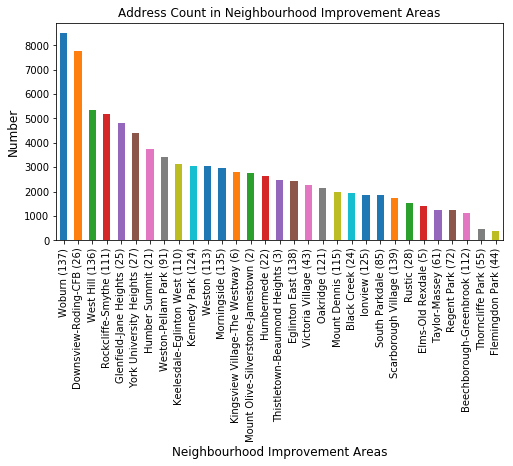

In [43]:
# distribution of addresses in nia_address

#plot
plt.figure(figsize=(8,4))

plt.title("Address Count in Neighbourhood Improvement Areas")
plt.ylabel('Number', fontsize=12)
plt.xlabel('Neighbourhood Improvement Areas', fontsize=12)

nia_address.area_name.value_counts().plot.bar()

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Walking Times To Closest TTC Stop')

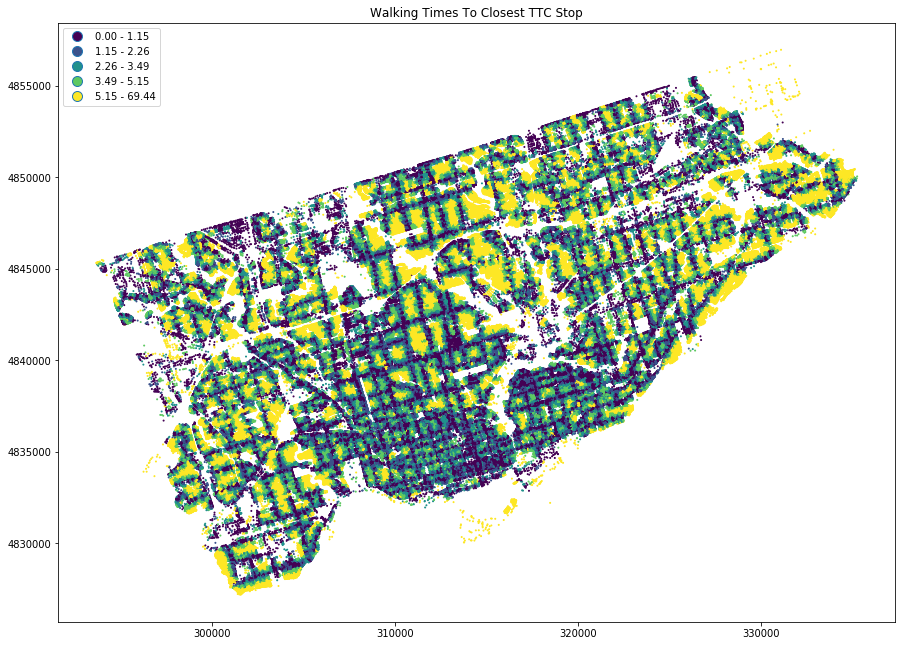

In [44]:
# Walking Times To Closest TTC Stop
ax = address.plot(figsize=(15, 15), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 1)
plt.title('Walking Times To Closest TTC Stop')

###  Average Walking Times To Closest TTC Stop in Neighbourhood Improvement Areas

We will now use the mean function to calculate the mean walking time to the closest TTC stop for each of the Neighbourhood Improvement Areas.

In [45]:
mins_avgs = nia_address.groupby('area_name')['m_ttcstop_0'].mean()
mins_avgs

area_name
Beechborough-Greenbrook (112)            3.039773
Black Creek (24)                         2.349726
Downsview-Roding-CFB (26)                3.761887
Eglinton East (138)                      3.714964
Elms-Old Rexdale (5)                     5.657795
Flemingdon Park (44)                     3.871380
Glenfield-Jane Heights (25)              3.894187
Humber Summit (21)                       3.712015
Humbermede (22)                          4.685585
Ionview (125)                            3.219054
Keelesdale-Eglinton West (110)           3.203814
Kennedy Park (124)                       2.873645
Kingsview Village-The Westway (6)        3.430494
Morningside (135)                        5.973554
Mount Dennis (115)                       2.183338
Mount Olive-Silverstone-Jamestown (2)    4.621906
Oakridge (121)                           2.441183
Regent Park (72)                         1.732689
Rockcliffe-Smythe (111)                  2.678972
Rustic (28)                             

In [46]:
# renaming axixs to area_name and resetting index to nia_addr_avg_min
nia_addr_avg_min = mins_avgs.rename_axis('area_name').reset_index(name='nia_addr_avg_min')
nia_addr_avg_min

# merge nia_address with nia_addr_avg_min using area_name
nia_address = pd.merge(nia_address, nia_addr_avg_min)

nia_address.head(2)

area_id area_s_cd                     area_name                                           geometry                                      center  index_right    geo_id maint_stag address     lfname           x            y  longitude   latitude   objectid    mun_name    ward_name  node_ids  d_ttcstop_0  d_ttcstop_1  d_ttcstop_2  d_ttcstop_3  d_ttcstop_4  d_ttcstop_5  d_ttcstop_6  d_ttcstop_7  d_ttcstop_8  d_ttcstop_9  m_ttcstop_0  m_ttcstop_1  m_ttcstop_2  m_ttcstop_3  m_ttcstop_4  m_ttcstop_5  m_ttcstop_6  m_ttcstop_7  m_ttcstop_8  m_ttcstop_9  nia_address_count  nia_addr_avg_min
0  25886593       027  York University Heights (27)  POLYGON ((304374.1999541915 4846441.251353574,...  POINT (305695.094973071 4847092.649532764)       235778   5479008    REGULAR     801  Alness St  306821.747  4848464.039 -79.474690  43.778133  4077110.0  North York  York Centre     46986    17.052999    17.052999    40.183998   310.848999   310.848999   331.356995   331.356995   421.743988   448.212006   545.502014     0.236847     0.236847     0.558111     4.317347     4.317347      4.60218      4.60218     5.857555     6.225167     7.576417               4399          3.263771
1  25886593       027  York University Heights (27)  POLYGON ((304374.1999541915 4846441.251353574,...  POINT (305695.094973071 4847092.649532764)       235779  30073785    REGULAR     803  Alness St  306827.883  4848466.084 -79.474613  43.778151  4077097.0  North York  York Centre     46986    17.052999    17.052999    40.183998   310.848999   310.848999   331.356995   331.356995   421.743988   448.212006   545.502014     0.236847     0.236847     0.558111     4.317347     4.317347      4.60218      4.60218     5.857555     6.225167     7.576417               4399          3.263771

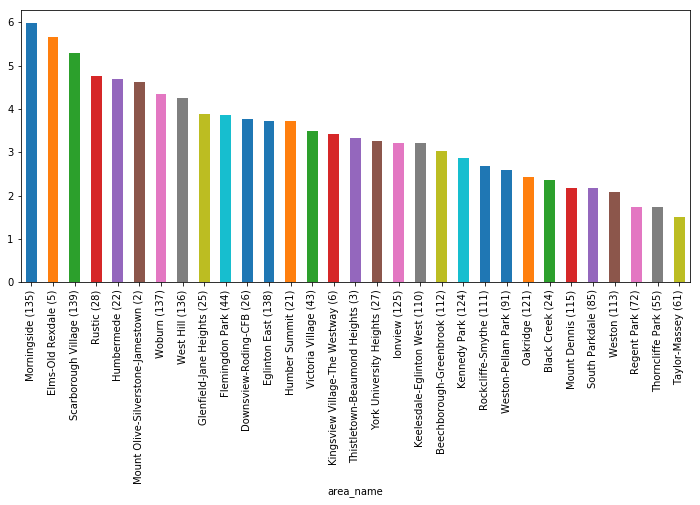

In [47]:
# plot bar plot
plt.figure(figsize=(12,5))
nia_address_bar = nia_address.groupby(['area_name'])['m_ttcstop_0'].mean()

nia_address_bar.sort_values(ascending=False).plot.bar()




### Plot Average Walking times to the Closest TTC Stop for each Neighbourhood Improvement Area

Text(0.1, 0.08, 'Source: Toronto Open Data')

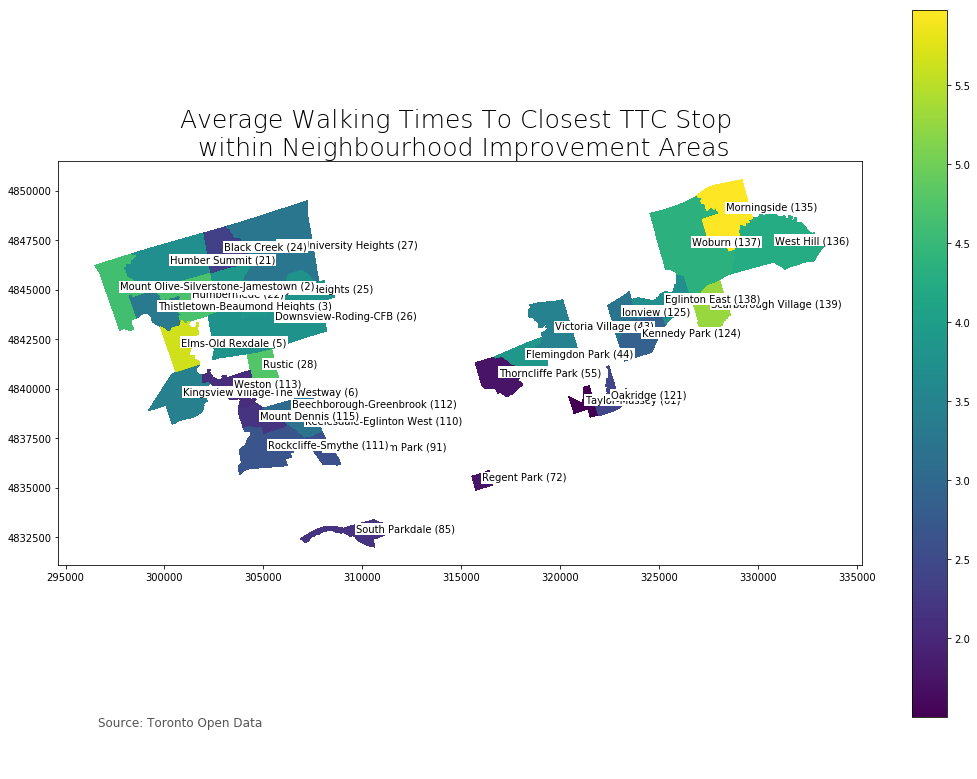

In [48]:
# plot Average Walking Times To Closest TTC Stop in Neighbourhood Improvement Areas
ax = nia_address.plot(figsize=(18, 13), column='nia_addr_avg_min', legend=True)
ax.set_title('Average Walking Times To Closest TTC Stop \n within Neighbourhood Improvement Areas', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Plot labels and add a white box behind the label using the matplotlib bbox class.
for x, y, label in zip(nia_points.geometry.x, nia_points.geometry.y, nia_points["area_name"]):
    texts.append(plt.text(x, y, label, fontsize = 10, bbox=dict(boxstyle='square,pad=0.1', fc='white', ec='none')))
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')


#### Get bounds of each Neighbourhood Improvement Area polygon
We will list all of the Neighbourhood Improvement Areas. Select the index_left value corresponding to the Neighbourhood Improvement Area you want to display in the dataframe bell. We will use the bounding box function to obtain the polygon coordinates for each Neighbourhood Improvement Area. We will then use the bound box coordinates for a particular Neighbourhood Improvement Area polygon to show the walking times within the Neighbourhood Improvement Area.

In [49]:
# index_left and area_name
nia.area_name


index_left
0              York University Heights (27)
1          Thistletown-Beaumond Heights (3)
2                     Thorncliffe Park (55)
3                               Rustic (28)
4                 Scarborough Village (139)
5                       South Parkdale (85)
6                        Taylor-Massey (61)
7                        Humber Summit (21)
8                           Humbermede (22)
9                      Flemingdon Park (44)
10                            Ionview (125)
11              Glenfield-Jane Heights (25)
12                    Victoria Village (43)
13                          West Hill (136)
14                       Kennedy Park (124)
15        Kingsview Village-The Westway (6)
16           Keelesdale-Eglinton West (110)
17                       Mount Dennis (115)
18            Beechborough-Greenbrook (112)
19                           Oakridge (121)
20                      Eglinton East (138)
21                     Elms-Old Rexdale (5)
22                   

In [50]:
# Get bounding box coordinates and area name for a particular Neighbourhood Improvement Area
# Pick index number from the list above and place it in the []
minx,miny,maxx,maxy = nia.bounds.iloc[4].values
# Pick the same index number from the list above and place it in the [] to get the area name 
nia_area_name = nia.area_name.iloc[4]
nia_area_name


'Scarborough Village (139)'

#### Plotting Neighbourhood Improvement Area using bounding box co-ordinates

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.1, 0.05, 'Source: Toronto Open Data')

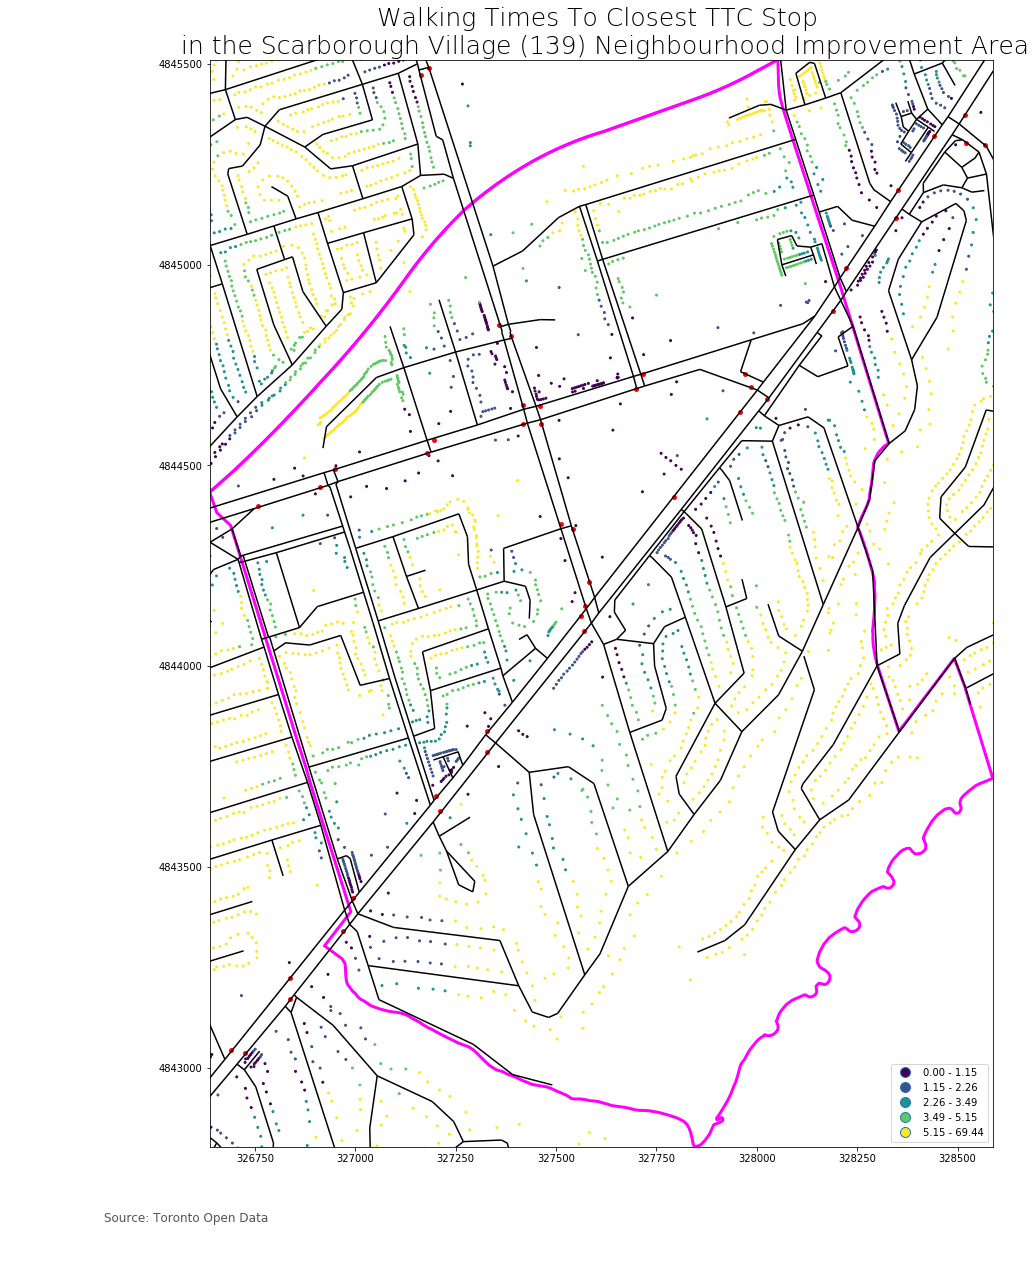

In [51]:
### plotting Neighbourhood Improvement Area using bounding box co-ordinates
#name = nia_area_name
ax = address.plot(figsize=(20, 20), column='m_ttcstop_0', scheme='quantiles', legend=True,markersize = 4)
nia.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)
ttc_stop.plot(ax=ax, color='red', markersize =15)
pednet.plot(ax=ax,color='black', markersize =1)

# getting limits
ax.set(xlim=(minx, maxx), ylim=(miny, maxy))

# add a title
ax.set_title((('Walking Times To Closest TTC Stop \n in the {0} Neighbourhood Improvement Area').format(nia_area_name)), fontdict={'fontsize': '25', 'fontweight' : '3'})
# create an annotation for the data source
ax.annotate('Source: Toronto Open Data',xy=(0.1, .05),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

#option to save figure
#fig.savefig("./ttc_stop_walkability.png", dpi=300)